In [92]:
import numpy as np
import pandas as pd
import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta

import matplotlib.pyplot as plt 
import seaborn as sns

In [93]:
# stock ticker to visualize
ticker = '^SPX'

# fetch last 10 years of close prices with yfinance
startDate = datetime.now() - timedelta(days=365 * 10)
endDate = datetime.now()
prices = yf.download(tickers=ticker, start=startDate, end=endDate)

prices = prices['Close']
print(prices.tail())

[*********************100%%**********************]  1 of 1 completed

Date
2024-01-12    4783.830078
2024-01-16    4765.979980
2024-01-17    4739.209961
2024-01-18    4780.939941
2024-01-19    4839.810059
Name: Close, dtype: float64


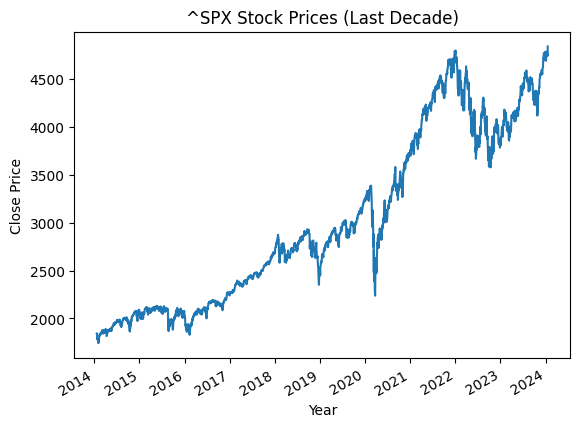

In [94]:
# plot prices in plot
prices.plot(title=f'{ticker} Stock Prices (Last Decade)')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.show()

In [95]:
# scale date to between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

prices = prices.values.reshape(-1, 1)
prices = scaler.fit_transform(prices)

# Train Test Split
The training set and splitting test will be split into the following:
1. The training set will be the first 7 years.
2. The testing set will be the last 3 years.

In [96]:
# run train test split
split_point = round(0.7 * len(prices))
train_set = prices[:split_point]
test_set = prices[split_point:]

In [97]:
# turn into time series dataset
def createDataset(dataset, look_back):
	dataX, dataY = [], []
	
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
		
	return np.array(dataX), np.array(dataY)

# create X_train, y_train, X_test, y_test
lookback = 365 # use last 2 year's prices to predict next day's price
X_train, y_train = createDataset(train_set, lookback)
X_test, y_test = createDataset(test_set, lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1396, 365) (1396,)
(389, 365) (389,)


In [98]:
# reshape training sets
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Model design
The GRU network will have 2 layers of 50 GRU units. The model will be trained with 50 epochs and a batch size of 200.

Epoch 1/50
7/7 - 5s - loss: 0.0255 - val_loss: 0.0292 - 5s/epoch - 673ms/step
Epoch 2/50
7/7 - 0s - loss: 0.0086 - val_loss: 0.0569 - 78ms/epoch - 11ms/step
Epoch 3/50
7/7 - 0s - loss: 0.0048 - val_loss: 0.0164 - 66ms/epoch - 9ms/step
Epoch 4/50
7/7 - 0s - loss: 0.0037 - val_loss: 0.0562 - 66ms/epoch - 9ms/step
Epoch 5/50
7/7 - 0s - loss: 0.0031 - val_loss: 0.0176 - 69ms/epoch - 10ms/step
Epoch 6/50
7/7 - 0s - loss: 0.0028 - val_loss: 0.0269 - 64ms/epoch - 9ms/step
Epoch 7/50
7/7 - 0s - loss: 0.0024 - val_loss: 0.0171 - 70ms/epoch - 10ms/step
Epoch 8/50
7/7 - 0s - loss: 0.0022 - val_loss: 0.0152 - 74ms/epoch - 11ms/step
Epoch 9/50
7/7 - 0s - loss: 0.0020 - val_loss: 0.0132 - 80ms/epoch - 11ms/step
Epoch 10/50
7/7 - 0s - loss: 0.0019 - val_loss: 0.0109 - 75ms/epoch - 11ms/step
Epoch 11/50
7/7 - 0s - loss: 0.0018 - val_loss: 0.0110 - 79ms/epoch - 11ms/step
Epoch 12/50
7/7 - 0s - loss: 0.0017 - val_loss: 0.0082 - 75ms/epoch - 11ms/step
Epoch 13/50
7/7 - 0s - loss: 0.0016 - val_loss: 0.009

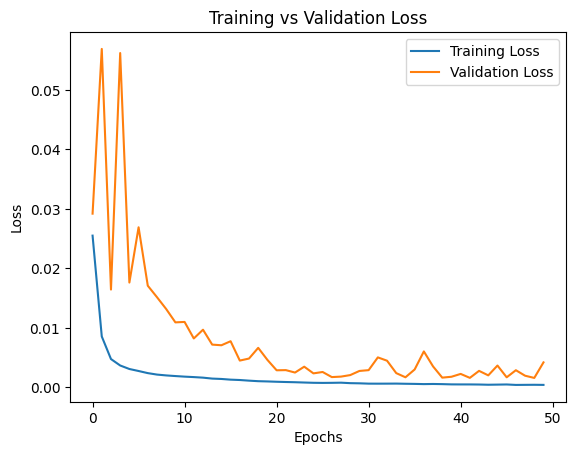

In [99]:
# create GRU network
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(GRU(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit GRU network
history = model.fit(X_train, y_train, epochs=50, batch_size=200, verbose=2, validation_data=(X_test, y_test))

# create model train vs validation loss graph to determine overfitting/underfitting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## RMSE Error Calculation

In [100]:
# make predictions for both training and testing data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

13/13 [==============================] - 0s 2ms/step


In [101]:
# calculate train score
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
print('Train Score: %.2f RMSE' % (train_score))

# calculate test score
test_score = np.sqrt(mean_squared_error(y_test, test_predict))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 0.02 RMSE
Test Score: 0.06 RMSE


# Train and Test Predictions vs Historical Prices Visualization

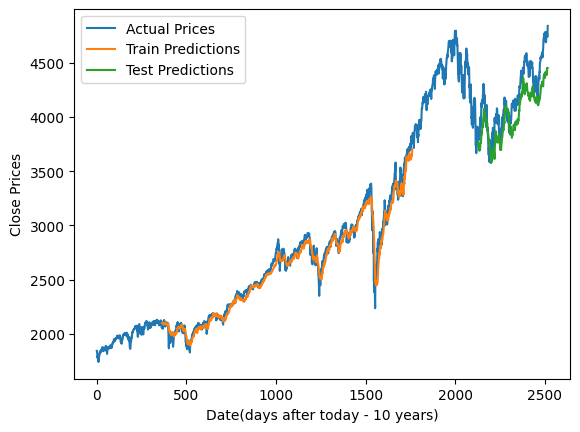

In [102]:
# inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(train_predict)+lookback, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(prices)-1, :] = test_predict

plt.plot(scaler.inverse_transform(prices), label='Actual Prices')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.ylabel('Close Prices')
plt.xlabel('Date(days after today - 10 years)')
plt.legend()
plt.show()

# Create Forecast

In [103]:
# define forecast for 2 years
forecast_days = 365 * 2

# copy last lookback's prices
forecast_prices = prices[-lookback:]

# loop over every day in forecast period and forecast with model
for i in range(forecast_days):
    # Reshape the data to match the input shape of the model
    forecast_prices = np.reshape(forecast_prices[-lookback:], (1, 1, lookback))

    # Use the model to predict the next day's price
    next_day_price = model.predict(forecast_prices)

    # Inverse transform the scaled price back to the original range
    next_day_price = scaler.inverse_transform(next_day_price)
    print(next_day_price)

    # Append the predicted price to the forecast_prices array
    forecast_prices = np.append(forecast_prices, next_day_price)

1/1 [==============================] - 0s 17ms/step
[[4443.319]]
1/1 [==============================] - 0s 13ms/step
[[4417.036]]
1/1 [==============================] - 0s 16ms/step
[[4831.1987]]
1/1 [==============================] - 0s 14ms/step
[[5530.618]]
1/1 [==============================] - 0s 17ms/step
[[5132.5586]]
1/1 [==============================] - 0s 14ms/step
[[5812.1685]]
1/1 [==============================] - 0s 19ms/step
[[6082.5557]]
1/1 [==============================] - 0s 27ms/step
[[5368.5015]]
1/1 [==============================] - 0s 14ms/step
[[5485.7]]
1/1 [==============================] - 0s 21ms/step
[[5930.397]]
1/1 [==============================] - 0s 19ms/step
[[5873.215]]
1/1 [==============================] - 0s 21ms/step
[[6088.726]]
1/1 [==============================] - 0s 18ms/step
[[6379.7563]]
1/1 [==============================] - 0s 18ms/step
[[5434.3115]]
1/1 [==============================] - 0s 27ms/step
[[6406.055]]
1/1 [===============

# Forecast Visualization next to Historical Prices

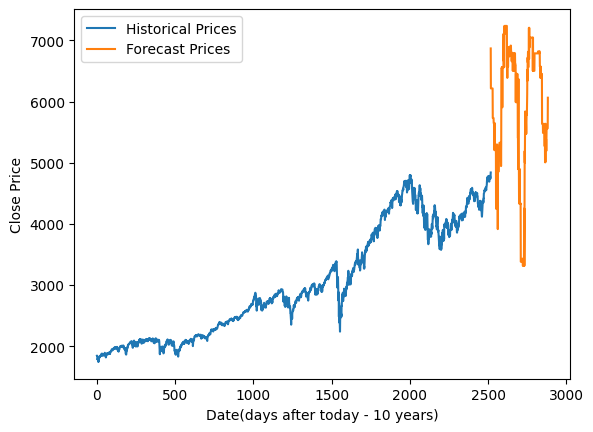

In [104]:
# plot historical prices
plt.plot(scaler.inverse_transform(prices), label='Historical Prices')

# set forecast price range and plot forecast prices
forecast_range = range(len(prices)-1, len(prices)+len(forecast_prices)-1)
plt.plot(forecast_range, forecast_prices, label='Forecast Prices')

# add labels and legend
plt.xlabel('Date(days after today - 10 years)')
plt.ylabel('Close Price')
plt.legend()

plt.show()